('month', 'lat', 'lon') (12, 36, 72) {'units': 'ppb'}


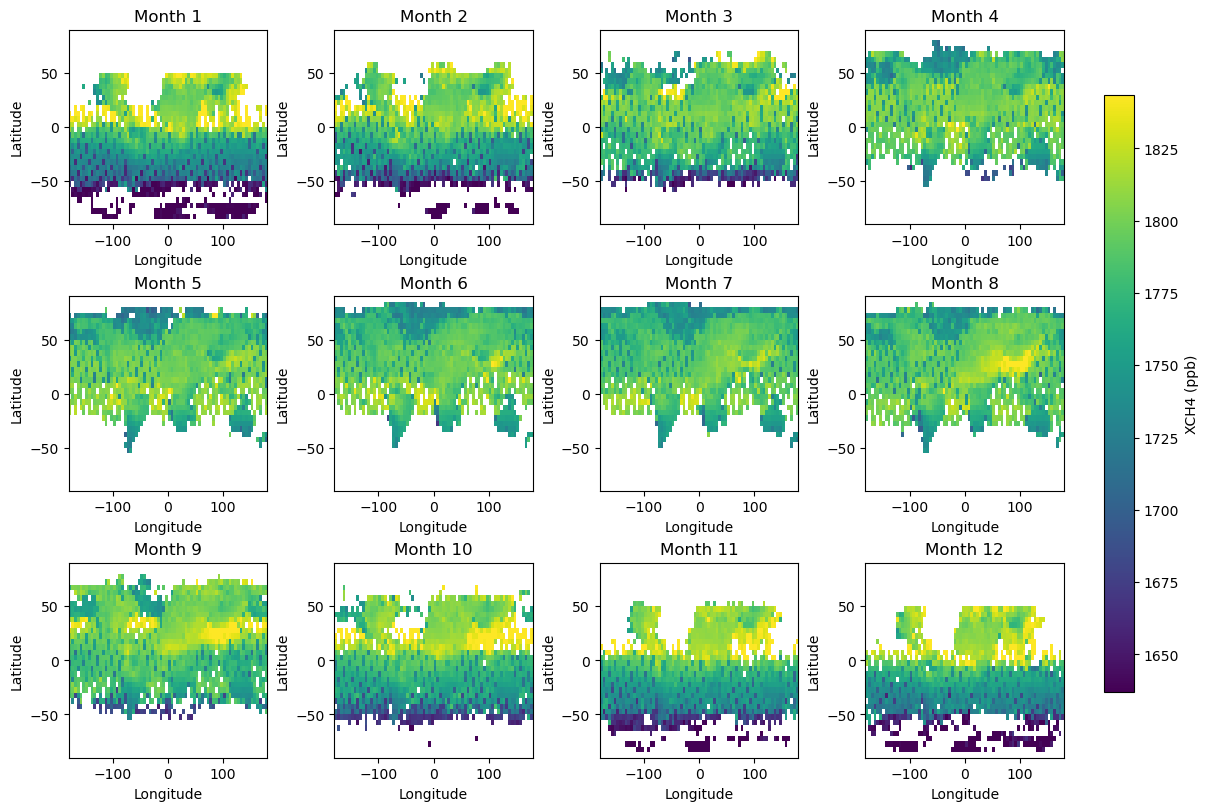

In [25]:
# homework1.1
import netCDF4
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
ds = xr.open_dataset("200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc", engine="netcdf4")


xch4 = ds["xch4"]  # dims: (time, lat, lon)


# fill = xch4.attrs.get("fill_value", None)
# if fill is not None:
#     xch4 = xch4.where(xch4 != fill)

xch4 = ds["xch4"]
xch4 = xch4.where(xch4 != 1e20, np.nan)

if xch4.attrs.get("units", "").strip() in ["1", "", None]:
    xch4 = xch4 * 1e9
    xch4.attrs["units"] = "ppb"


xch4_clim = xch4.groupby("time.month").mean(dim="time", skipna=True)


print(xch4_clim.dims, xch4_clim.shape, xch4_clim.attrs)



vmin = float(xch4_clim.quantile(0.02))
vmax = float(xch4_clim.quantile(0.98))


fig, axes = plt.subplots(3, 4, figsize=(12, 8), constrained_layout=True)


axes = axes.flatten()

for m in range(1, 13): 
    ax = axes[m-1]      
    
    
    data = xch4_clim.sel(month=m)
    
    
    im = ax.pcolormesh(data["lon"], data["lat"], data,
                       cmap="viridis", vmin=vmin, vmax=vmax)
    
    ax.set_title(f"Month {m}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")


cbar = fig.colorbar(im, ax=axes, orientation="vertical",
                    fraction=0.03, pad=0.04, label="XCH4 (ppb)")

plt.show()

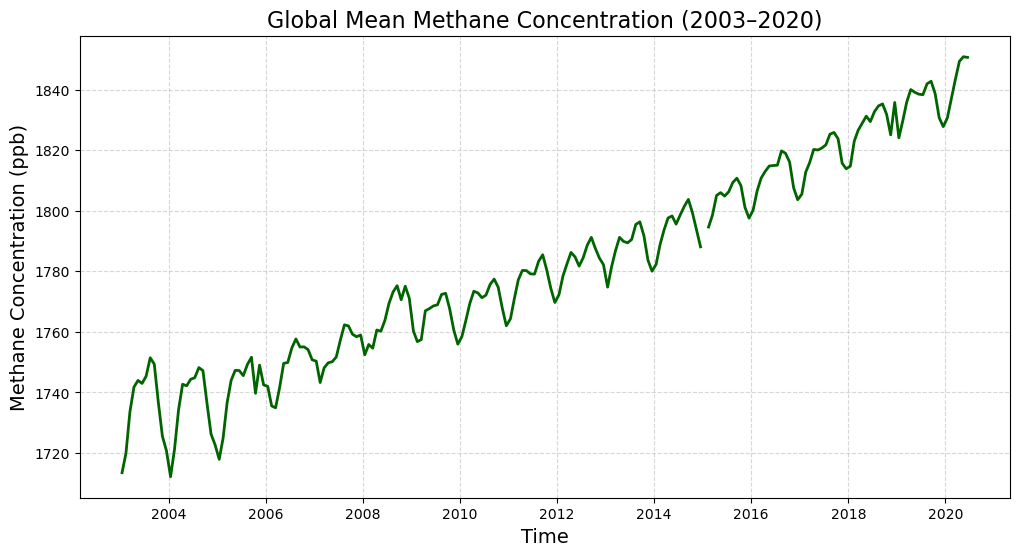

甲烷的浓度逐年增加，而且具有季节性，与所给的图对比，趋势基本相同


In [78]:
# homework1.2
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# 1. 读取数据
file_path = "200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc"
ds = xr.open_dataset(file_path)

# 2. 选择变量并处理缺失值
xch4 = ds["xch4"]
xch4 = xch4.where(xch4 != 1e20, np.nan)
xch4 = xch4 * 1e9
# 3. 计算全球平均浓度（加权平均，考虑纬度面积差异）
weights = np.cos(np.deg2rad(xch4["lat"]))
weights = weights / weights.mean()  # 归一化
global_mean = xch4.weighted(weights).mean(dim=["lat", "lon"])

# 4. 绘制时间序列图
plt.figure(figsize=(12,6))
plt.plot(global_mean["time"], global_mean, color="darkgreen", linewidth=2)

plt.title("Global Mean Methane Concentration (2003–2020)", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Methane Concentration (ppb)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()
print("甲烷的浓度逐年增加，而且具有季节性，与所给的图对比，趋势基本相同")

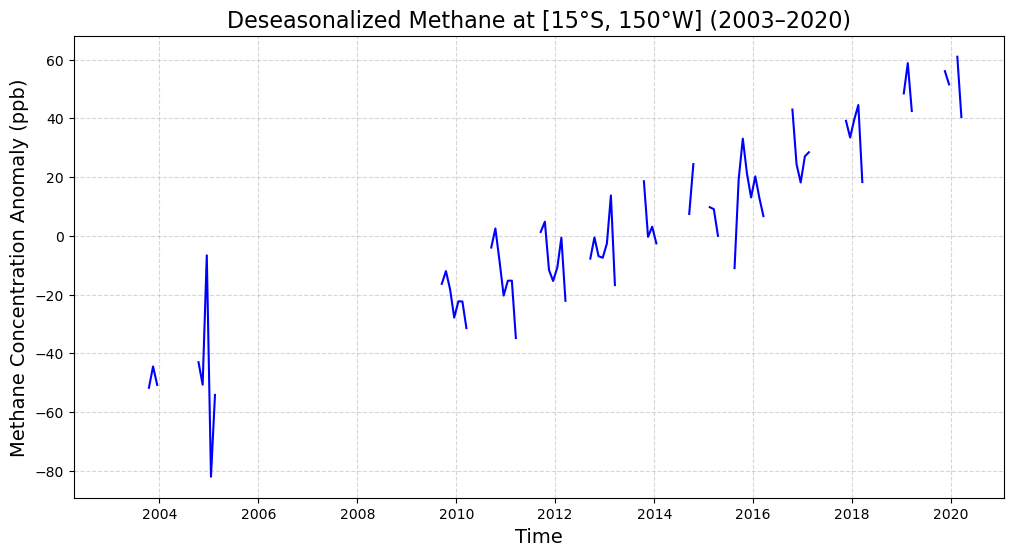

去季节化后，逐年上升的趋势更加明显了


In [79]:
# homework1.3
xch4 = ds["xch4"]
xch4 = xch4.where(xch4 != 1e20, np.nan)
xch4 = xch4 * 1e9
# 3. 提取指定点位的时间序列 (15°S, 150°W)
point_series = xch4.sel(lat=-15, lon=-150, method="nearest")

# 4. 计算气候态 (多年同月平均)
climatology = point_series.groupby("time.month").mean("time", skipna=True)

# 5. 去季节化：原始序列减去对应月份的气候态
deseasonalized = point_series.groupby("time.month") - climatology

# 6. 绘制时间序列图
plt.figure(figsize=(12,6))
plt.plot(deseasonalized["time"], deseasonalized, color="blue", linewidth=1.5)

plt.title("Deseasonalized Methane at [15°S, 150°W] (2003–2020)", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Methane Concentration Anomaly (ppb)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()
print("去季节化后，逐年上升的趋势更加明显了")

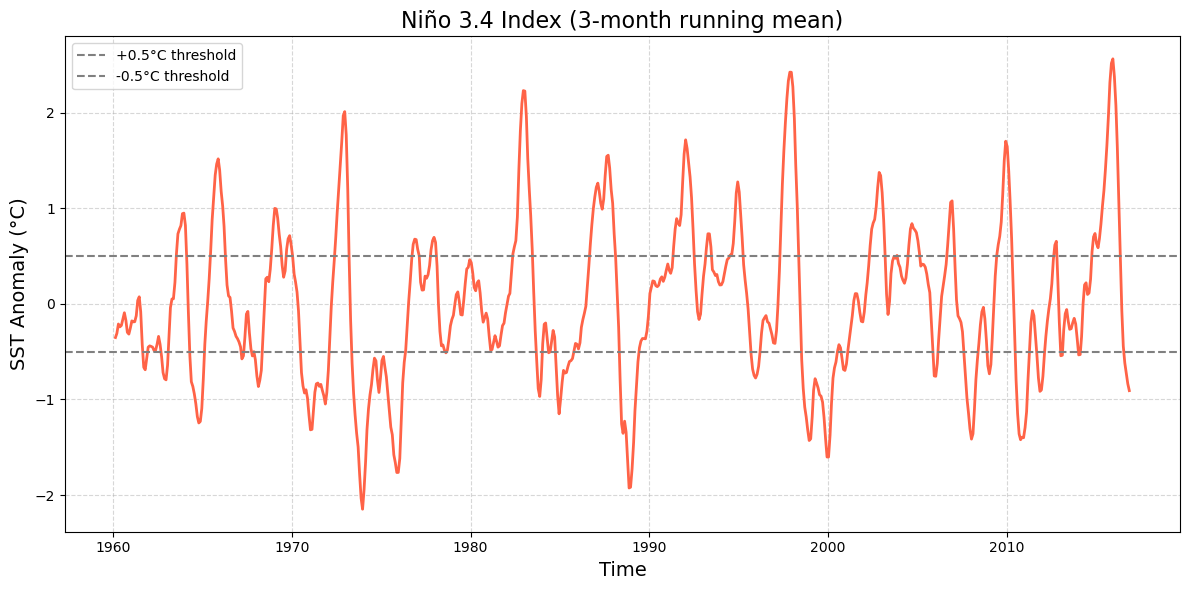

In [72]:
# homework2
import netCDF4
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


ds = xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc")
sst = ds["sst"] 

nino34 = sst.sel(lat=slice(-5, 5), lon=slice(190, 240))
nino34_mean = nino34.mean(dim=["lat", "lon"], skipna=True)
climatology = nino34_mean.groupby("time.month").mean("time", skipna=True)
anomalies = nino34_mean.groupby("time.month") - climatology
nino34_index = anomalies.rolling(time=3, center=True).mean()

plt.figure(figsize=(12,6))
plt.plot(nino34_index["time"], nino34_index, color="tomato", linewidth=2)
plt.axhline(0.5, color="gray", linestyle="--", label="+0.5°C threshold")
plt.axhline(-0.5, color="gray", linestyle="--", label="-0.5°C threshold")

plt.title("Niño 3.4 Index (3-month running mean)", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("SST Anomaly (°C)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

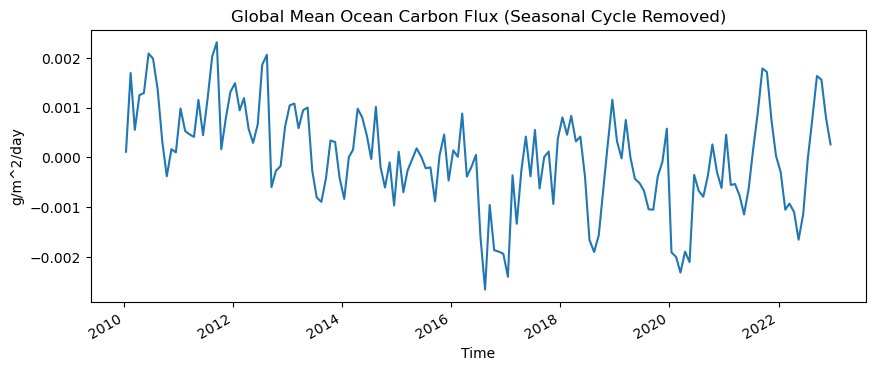

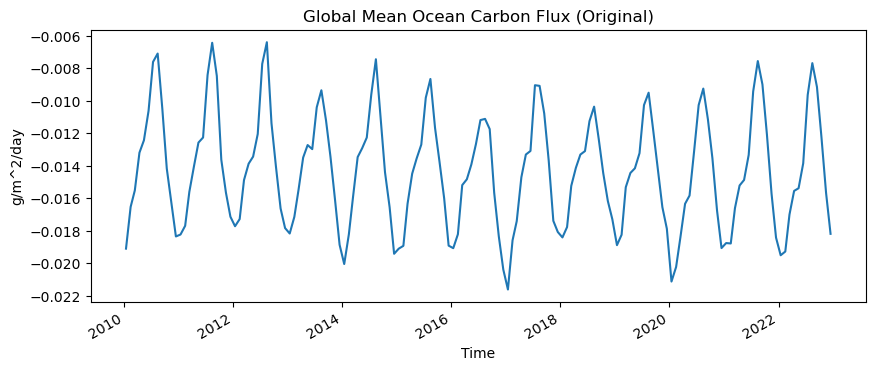

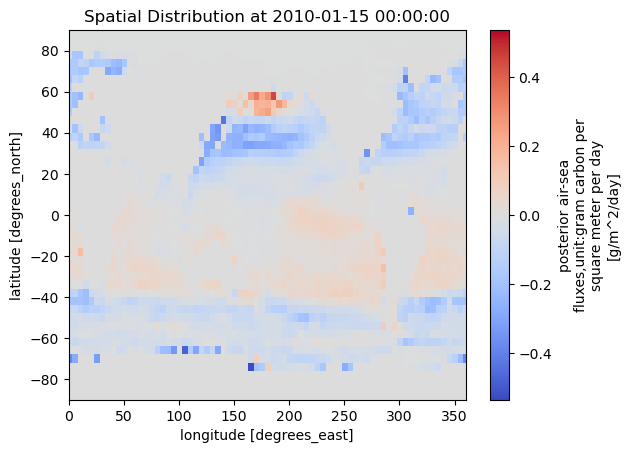

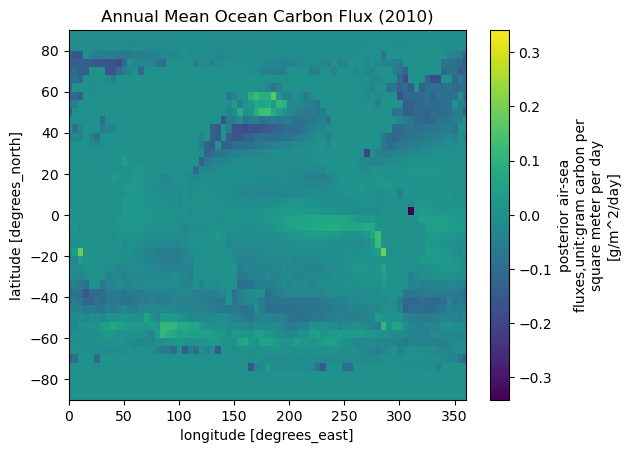

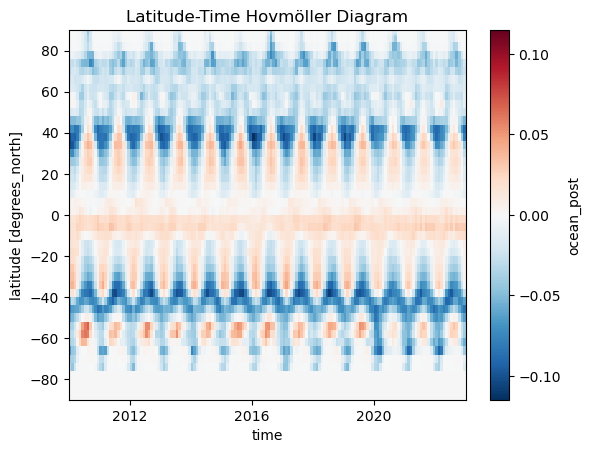

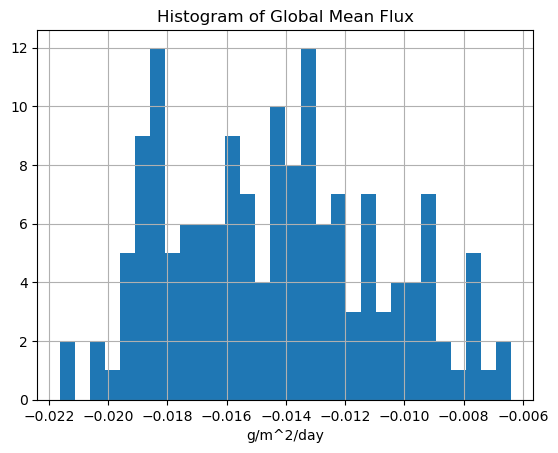

In [77]:
# homework 3
"""
数据来源是 NASA 戈达德地球科学数据和信息服务中心（GES DISC）的网站中的Carbon Monitoring System Carbon Flux Ocean L4 V3 (CMSFluxOcean)数据
"""
import xarray as xr
import cftime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#  打开数据，不解码时间
ds = xr.open_dataset("CMSFluxOcean201001_202212_v3.nc", decode_times=False)

#  修复时间坐标
time_var = ds['time'].values
base_date = cftime.DatetimeGregorian(2010, 1, 15)

def add_months(base, months):
    year = base.year + (base.month - 1 + months) // 12
    month = (base.month - 1 + months) % 12 + 1
    return cftime.DatetimeGregorian(year, month, base.day)

dates = [add_months(base_date, int(m)) for m in time_var]
ds = ds.assign_coords(time=dates)

var = ds['ocean_post']  # (time, latitude, longitude)

ts = var.mean(dim=['latitude','longitude'])

# 3.1 去季节化
time_index = pd.to_datetime([str(t) for t in ds.time.values])
ts_pd = ts.to_series()
ts_pd.index = time_index
monthly_clim = ts_pd.groupby(ts_pd.index.month).mean()
ts_anom = ts_pd - ts_pd.index.month.map(monthly_clim)


plt.figure(figsize=(10,4))
ts_anom.plot()
plt.title("Global Mean Ocean Carbon Flux (Seasonal Cycle Removed)")
plt.ylabel("g/m^2/day")
plt.xlabel("Time")
plt.show()

# 3.2 至少 5 种不同的图

# (1) 原始全球平均时间序列
plt.figure(figsize=(10,4))
ts_pd.plot()
plt.title("Global Mean Ocean Carbon Flux (Original)")
plt.ylabel("g/m^2/day")
plt.xlabel("Time")
plt.show()

# (2) 某一时刻的空间分布
var.isel(time=0).plot(cmap="coolwarm")
plt.title(f"Spatial Distribution at {str(ds.time.values[0])}")
plt.show()

# (3) 年均空间分布
annual_mean = var.groupby("time.year").mean(dim="time")
annual_mean.isel(year=0).plot(cmap="viridis")
plt.title("Annual Mean Ocean Carbon Flux (2010)")
plt.show()

# (4) 纬度平均剖面图（随时间变化）
lat_mean = var.mean(dim="longitude")
lat_mean.plot(x="time", y="latitude", cmap="RdBu_r")
plt.title("Latitude-Time Hovmöller Diagram")
plt.show()

# (5) 时间序列的直方图
plt.figure()
ts_pd.hist(bins=30)
plt.title("Histogram of Global Mean Flux")
plt.xlabel("g/m^2/day")
plt.show()